In [1]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from forecasting import mape_error, nmae_error
from models import *

import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

In [2]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

all_atms_feature_set = get_all_atms_feature_set(df, first_n = 15)

In [3]:
all_atms_feature_set = add_cluster_features(all_atms_feature_set,
    [('Day_of_the_Week_Index', 10),
    ('Special_Lunar_Dates_Index', 9),
    ('Month_of_the_Year_Index', 10)],
    'CashIn', KMeans)
    
all_atms_feature_set.sort_index(inplace = True)

In [4]:
categorical_features = [cat for cat in all_atms_feature_set.select_dtypes(include=['int8', 'int64'])
    if cat not in ['AtmId', 'Day_Index_0', 'Day_Index_1', 'Day_Index_2',
    'Day_Index_3', 'Day_Index_4', 'Day_Index_5', 'Day_Index_6', 'Is_Weekend',
    'curr_month_1_delta', 'curr_month_15_delta', 'next_month_1_delta',
    'is_ramazan', 'ramazan_in_7_days', 'is_kurban', 'kurban_in_7_days']]
continuous_features = [cont for cont in all_atms_feature_set.select_dtypes(include='float64')
    if cont not in ['CashIn', 'CashOut']]

all_features = []
all_features.extend(categorical_features)
all_features.extend(continuous_features)

X = all_atms_feature_set[all_features]
y = all_atms_feature_set['CashIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

train_pool = Pool(data = X_train, label = y_train, cat_features=categorical_features)

In [5]:
cb = CatBoostRegressor()
cb.fit(train_pool, verbose=0)

### MAPE Error

In [55]:
"Train score: %.4f, test score: %.4f" % (mape_error(cb.predict(X_train), y_train, use_index=False), mape_error(cb.predict(X_test), y_test, use_index=False))

'Train score: 27.8711, test score: 30.0195'

### NMAE Error

In [56]:
"Train score: %.4f, test score: %.4f" % (nmae_error(cb.predict(X_train), y_train), nmae_error(cb.predict(X_test), y_test))

'Train score: 0.2104, test score: 0.2707'

<AxesSubplot:xlabel='features'>

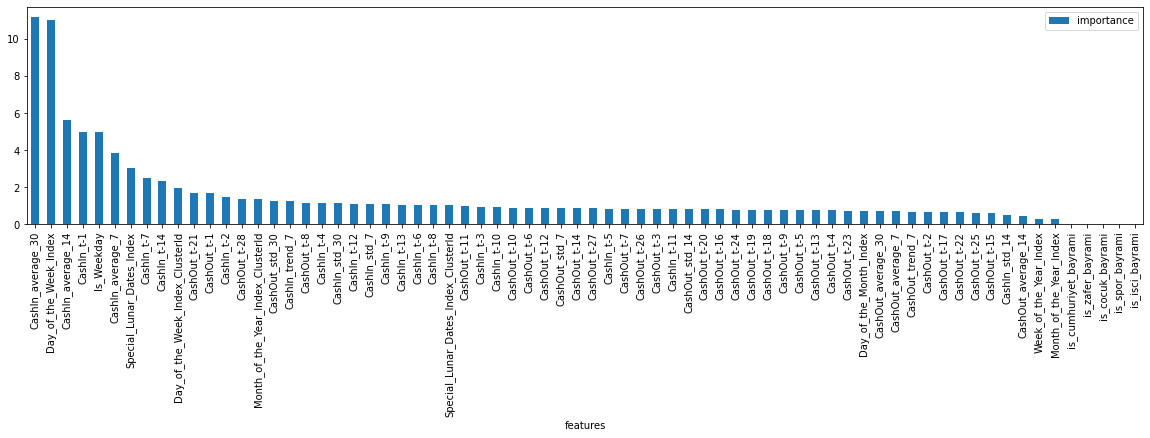

In [21]:
feature_importance = cb.get_feature_importance(train_pool)
importance_df = pd.DataFrame({'features':all_features, 'importance':feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df.plot.bar(x='features', y='importance',figsize=(20,4))


## Plotting

### Single ATM

In [ ]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [11]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [70]:
ATM_ID = 33793  
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
draw_model_error(cb, atm_feature_set[all_features], atm_feature_set['CashIn'], split_from=X_train.index[-1])

37.47445731979238


### Aggregate Error

In [69]:
y_pred = cb.predict(X)
mape_error(y, y_pred)

92.18980429740668

In [95]:
get_atm_df = lambda atm_id: all_atms_feature_set[all_atms_feature_set['AtmId'] == atm_id].resample('d').asfreq()

atm_ids = all_atms_feature_set['AtmId'].unique()
error_over_time = pd.Series(0, get_atm_df(atm_ids[0]).index)
for atm_id in atm_ids:
    atm_df = get_atm_df(atm_id)
    X_atm = atm_df[all_features]
    y_atm = atm_df['CashIn']

    y_pred = cb.predict(X_atm)
    error = get_error_with_freq(y_atm, y_pred)
    error_over_time += error

error_over_time /= len(atm_ids)
error_over_time = error_over_time.dropna()
error_over_time.mean()

92.33739960381199

In [96]:
import plotly.express as px

df = pd.DataFrame({'date': error_over_time.index, 'error':error_over_time})
fig = px.line(df, x="date", y="error", title='MAPE Error Over Time')
fig.show()

There are some spikes in the mape error over time plot above. This is probably caused by the low CashIn values in these weeks, which pushes the MAPE error to higher values.

In [112]:
# reference: https://plotly.com/python/bar-charts/

import plotly.graph_objects as go

N_BINS = 30

begin = error_over_time.min()
to = error_over_time.max()

bins = pd.Series(np.linspace(start = begin-1, stop = to + 1, num = N_BINS))

fig = go.Figure(data=[
    go.Bar(name='CashIn', x=bins, y=pd.cut(error_over_time, bins, right=False).value_counts(sort=False) ),
])

fig.update_layout(barmode='group')
fig.show()

Looking at the bin plot above, we can see that in majority of the weeks, models is performing well. Out of 207 weeks, 181 (87.4%) have MAPE error less than 21.8.